In [1]:
%cd ..

/Users/ani/Documents/time-series-forecasting


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.tsa.stattools import adfuller,pacf,acf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Load Data

In [3]:
df_train = pd.read_csv('./data/train.csv', low_memory=False)
df_test = pd.read_csv('./data/test.csv', low_memory=False)

# Transform Date column into datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [4]:
# Concatenate both sets into a single set for EDA for ease of use
# df = pd.concat([df_train, df_test])
df = df_train.copy(deep=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         230090 non-null  datetime64[ns]
 1   store        230090 non-null  int64         
 2   product      230090 non-null  int64         
 3   number_sold  230090 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 7.0 MB


In [6]:
# Create helper features like day of the week, weekend, week number, month, quarter and year
df['day_of_week'] = df['Date'].dt.day_of_week
df['weekend'] = np.where(df['day_of_week'] > 4, 1, 0)
df['quarter'] = df['Date'].dt.quarter
df['week'] = df['Date'].dt.isocalendar().week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['day_of_year'] = df['Date'].dt.day_of_year

In [7]:
# compute difference between values for each store product combination y_diff_t = Y_t - Y_(t-1)
df.sort_values(by=['store', 'product'], inplace=True)
df['y_diff'] = df.groupby(['store', 'product'])['number_sold'].diff()

## 2.1 Plot Values over time for each Product Store Combination 

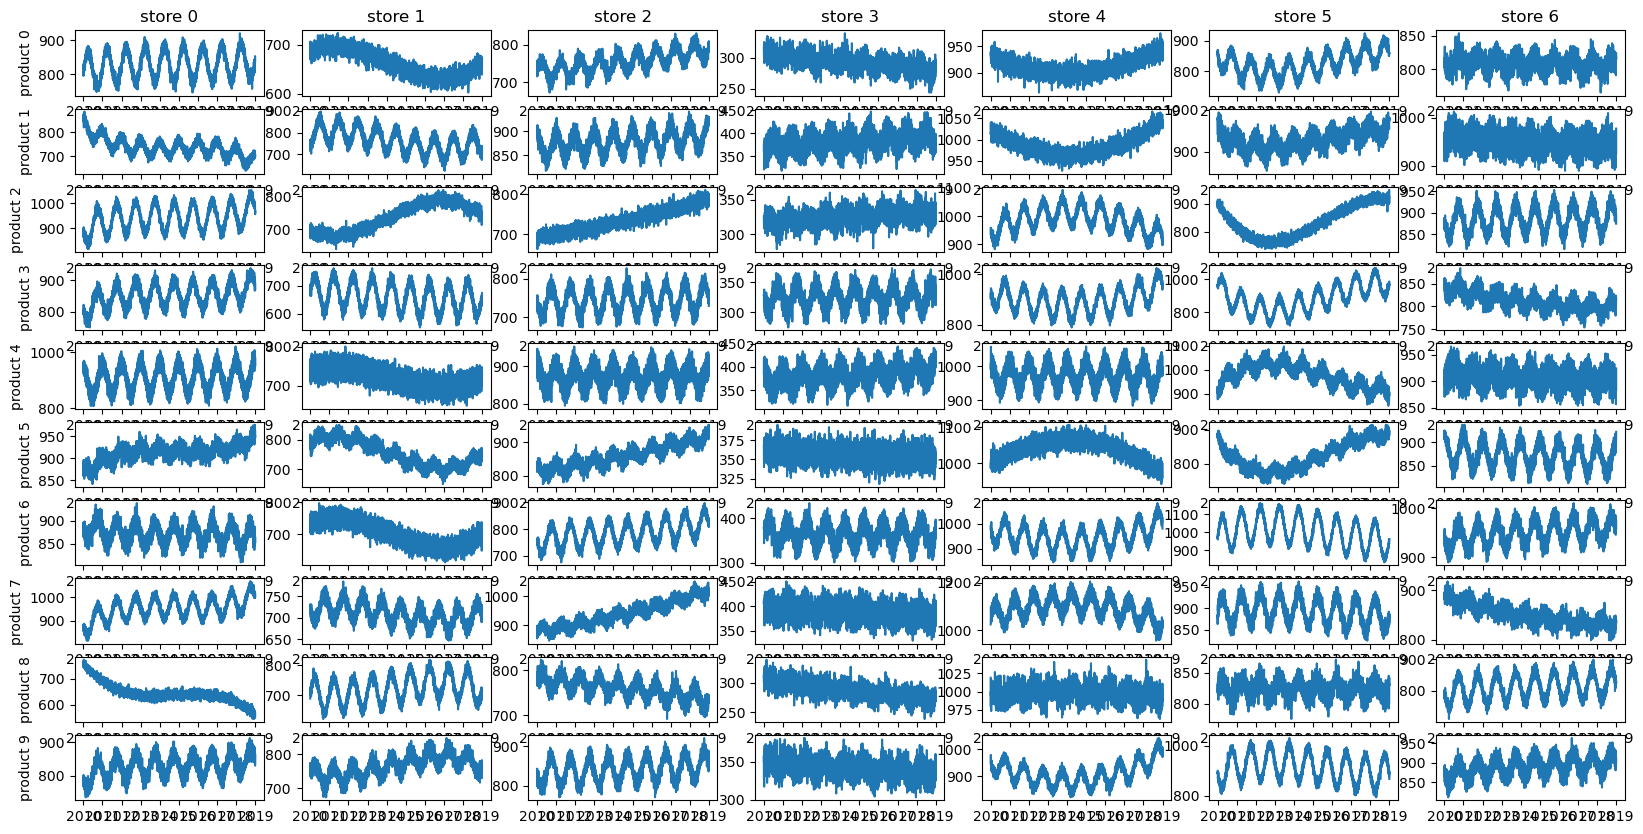

In [8]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='Date', y='number_sold', data=df[(df['store']==s) & (df['product']==p)], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

As seen from the table above, the mixture of all combinations is quite complex. For example:
- Product 1 and store 1 has a trend and also seasonality 
- Product 0 and store 1 has a trend (which has changed over time) but there seems no clear seasonality visible to the eye
- Product 7 and store 3 has no clear tren and no seasonality 

We see that product 0 and 2 are inversely correlated for store 1. One could say that the products are substitues, 
however this relationship is not visible in other stores so that does not hold. There are also other relationships that 
are clear to the eye across products and store
Overall the variance of all series is relatively constant over time, so there's no need for apply a transformation 
that would make variance constant over time

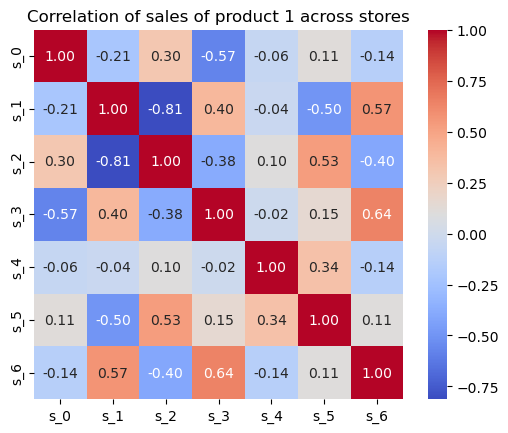

In [9]:
# Look at correlations
p=1
new_df = df[(df['store']==0) & (df['product']==p)].sort_values(by=['Date'])[['Date', 'number_sold']].copy(deep=True)
for s in range(0,7):
    new_df[f's_{s}'] = df[(df['store']==s) & (df['product']==p)].sort_values(by=['Date'])['number_sold'].values

sns.heatmap(new_df[new_df.columns[2:]].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f'Correlation of sales of product {p} across stores')
plt.show()
        

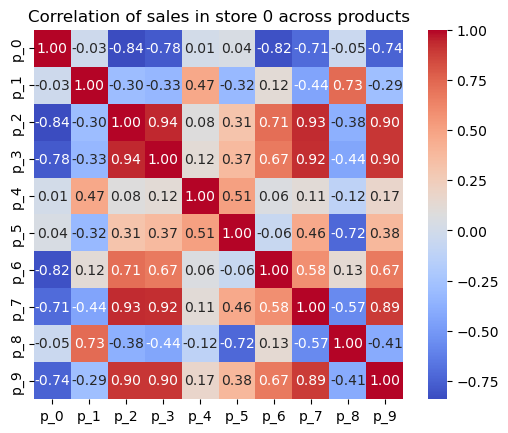

In [10]:
# Look at correlations
s=0
new_df = df[(df['store']==s) & (df['product']==0)].sort_values(by=['Date'])[['Date', 'number_sold']].copy(deep=True)
for p in range(0,10):
    new_df[f'p_{p}'] = df[(df['store']==s) & (df['product']==p)].sort_values(by=['Date'])['number_sold'].values

sns.heatmap(new_df[new_df.columns[2:]].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f'Correlation of sales in store {s} across products')
plt.show()
        

## 2.2 Plot avg sales by day of week

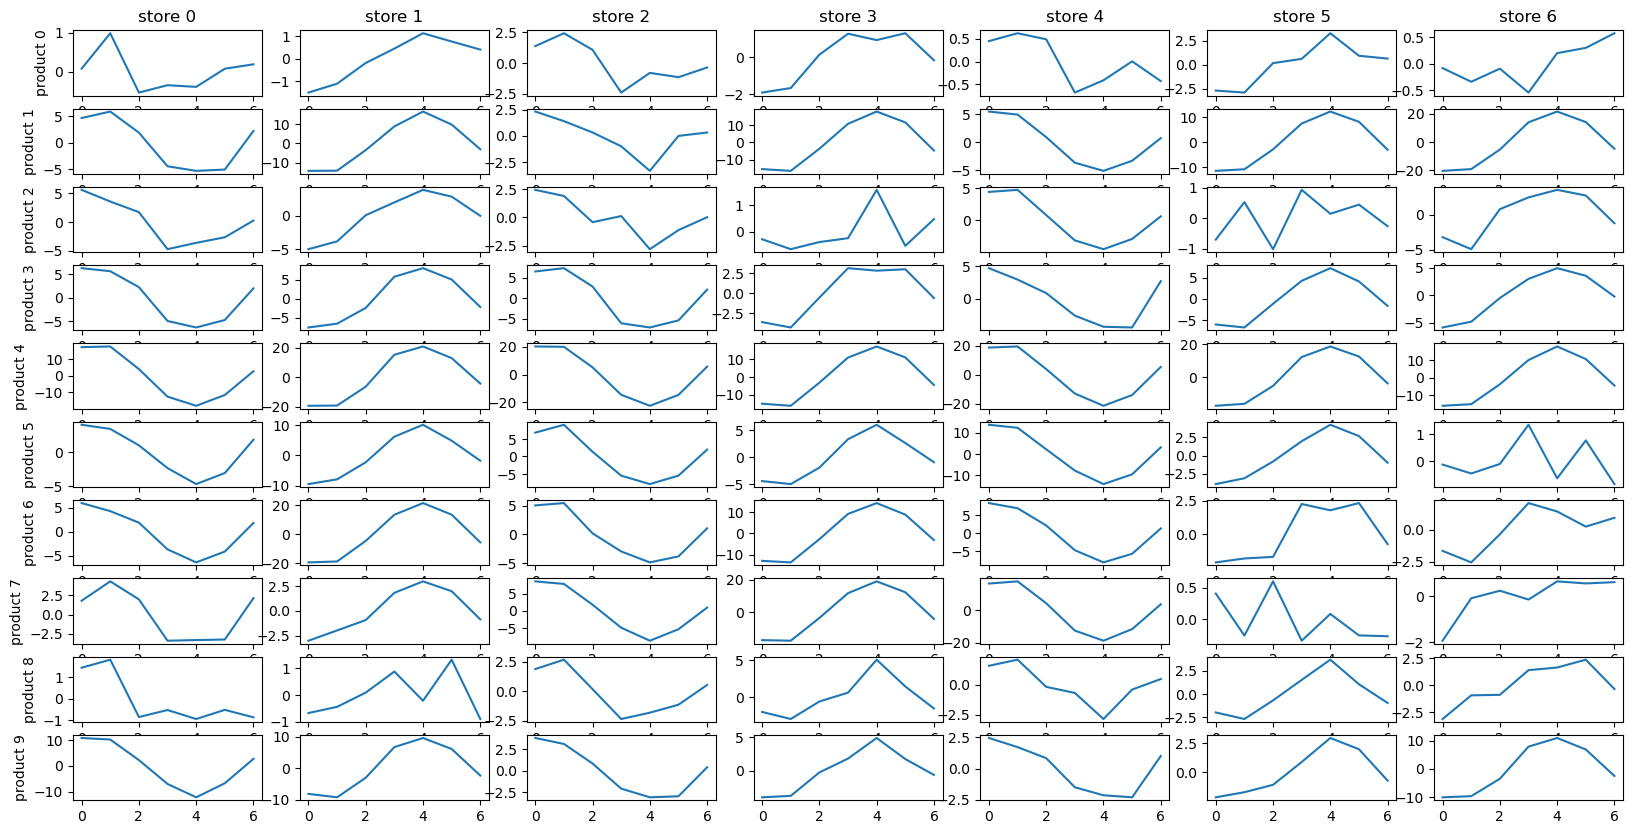

In [11]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

df_plot_quarter = df.groupby(['store', 'product', 'day_of_week'], as_index=False)['y_diff'].mean()
for s in range(7):
    for p in range(10):
        sns.lineplot(x='day_of_week', y='y_diff', data=df_plot_quarter[(df_plot_quarter['store']==s) & (df_plot_quarter['product']==p)], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

#### From the graph there seems to be a relationship between the day of the week and it's impact on sales

## 2.3 Plot Data yearly for all combinations

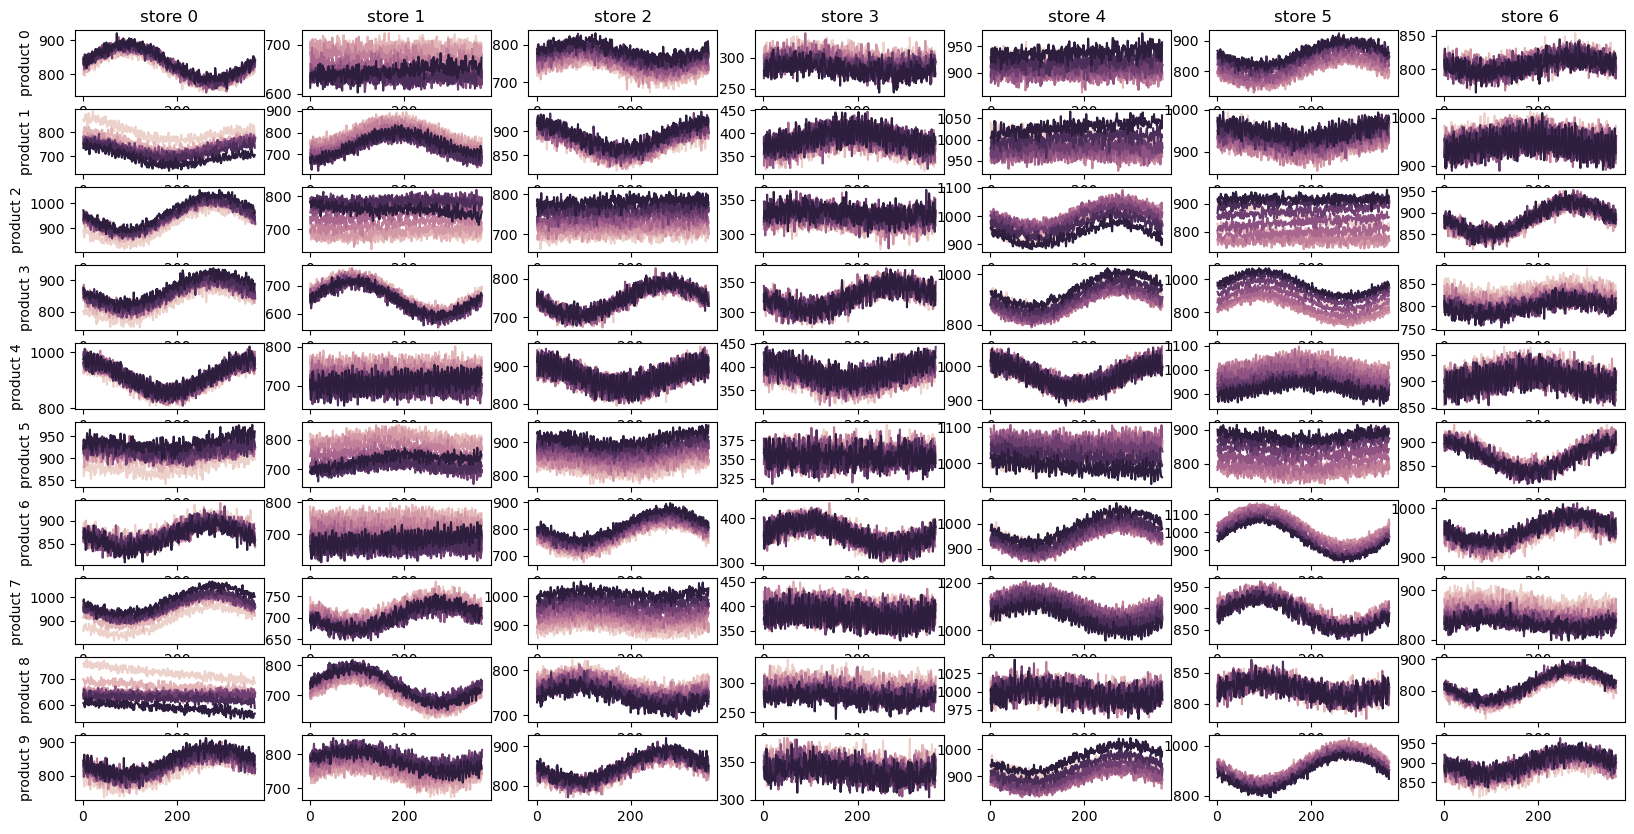

In [12]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='day_of_year', y='number_sold', data=df[(df['store']==s) & (df['product']==p)], hue='year', ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
        ax[p, s].legend_.remove()
    ax[0, s].set_title(f'store {s}')
    
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')
    

The pupose of the assignment is to build a time series model and then another regression model and combine the two. Fitting a time series model for each store product combination is possible however it is quite tedious. As we can see that the data fluctuates a lot year to year, it is best to use a time series model that captures the trend monthly and then use the regression model to adjust these predictions 

In [13]:
df_monthly = df.merge(
    df.groupby(
        ['store', 'product', 'year', 'month'], 
        as_index=False)['number_sold'].mean().rename(columns={'number_sold':'avg_monthly_sales'}),
    on = ['store', 'product', 'year', 'month']
)
df_monthly['month_deviation'] = df_monthly['number_sold'] - df_monthly['avg_monthly_sales']
    

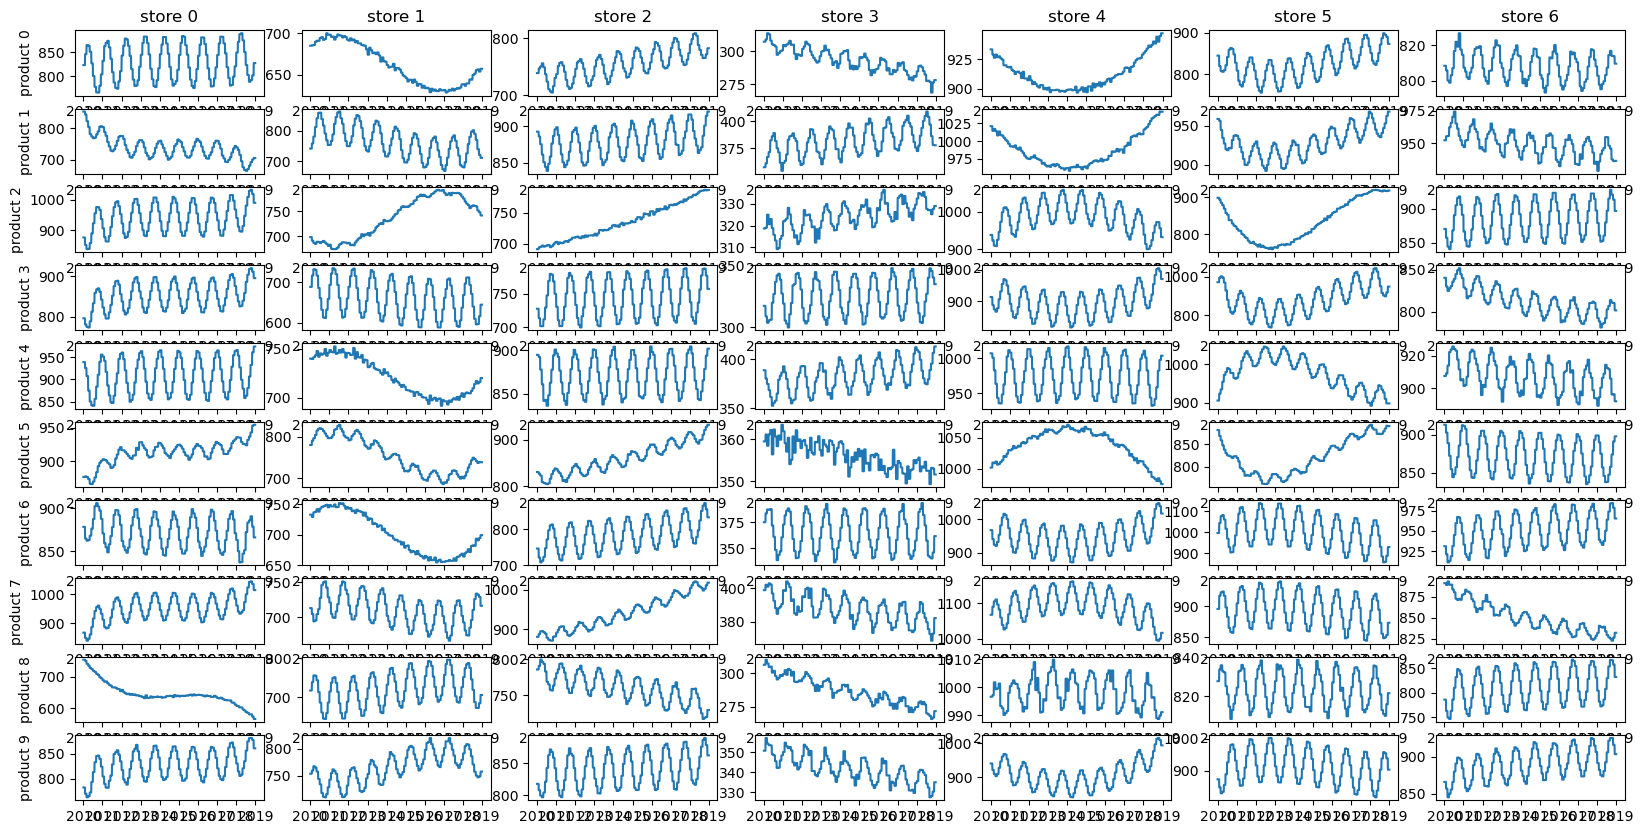

In [14]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='Date', y='avg_monthly_sales', data=df_monthly[(df_monthly['store']==s) & (df_monthly['product']==p)], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

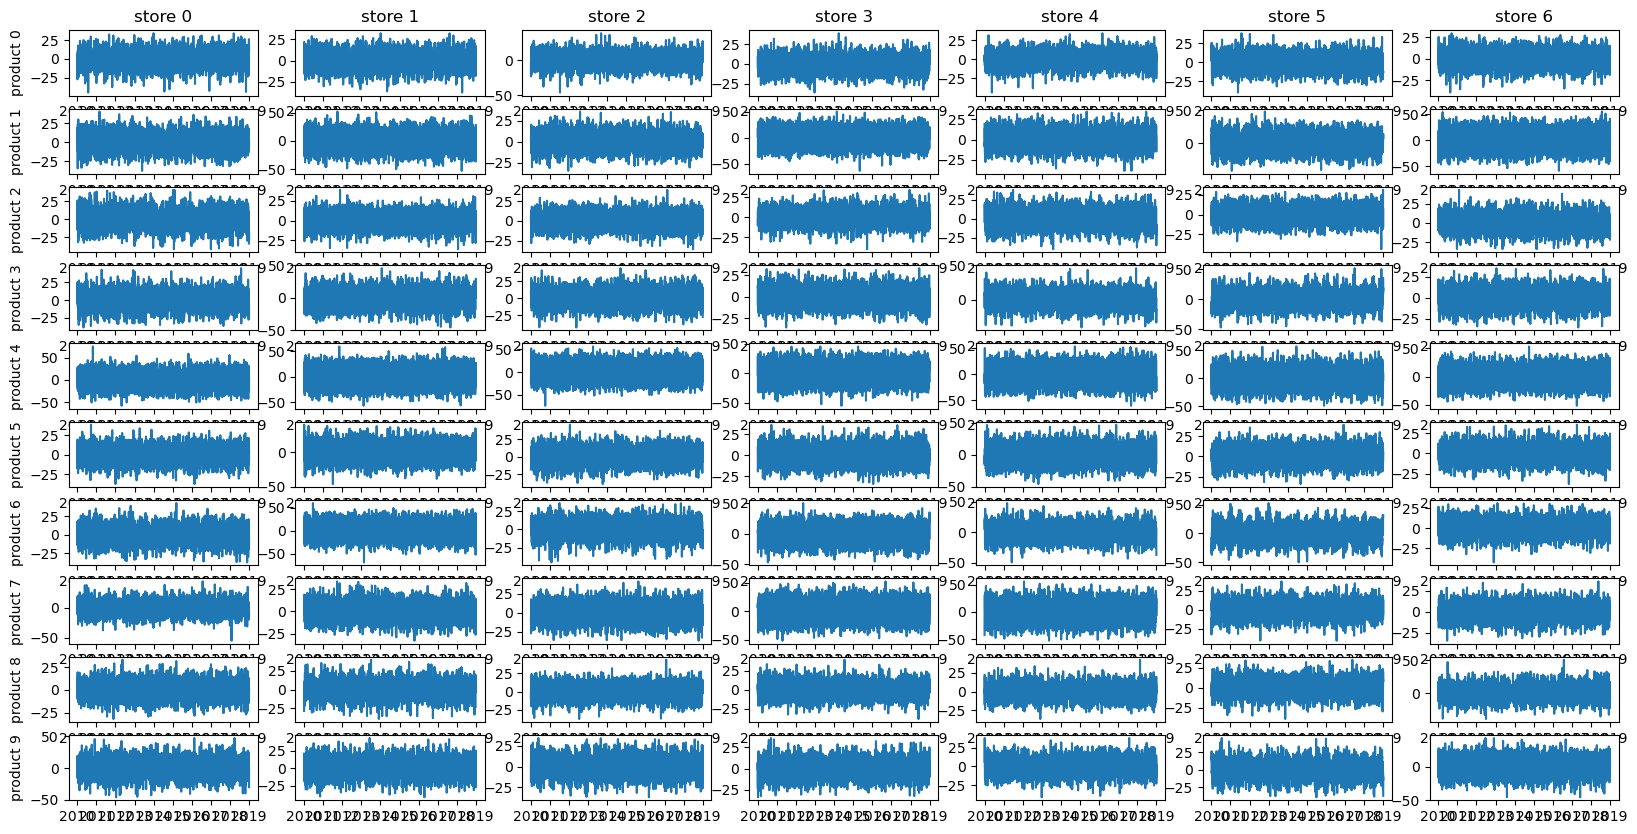

In [15]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='Date', y='month_deviation', data=df_monthly[(df_monthly['store']==s) & (df_monthly['product']==p)], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

As shown from the graph, predicting monthly, should suffice to capture the longterm trend of the data and removing the month average removes any trend from the data. 

## 2.4 Plot ACF for Monthly sales

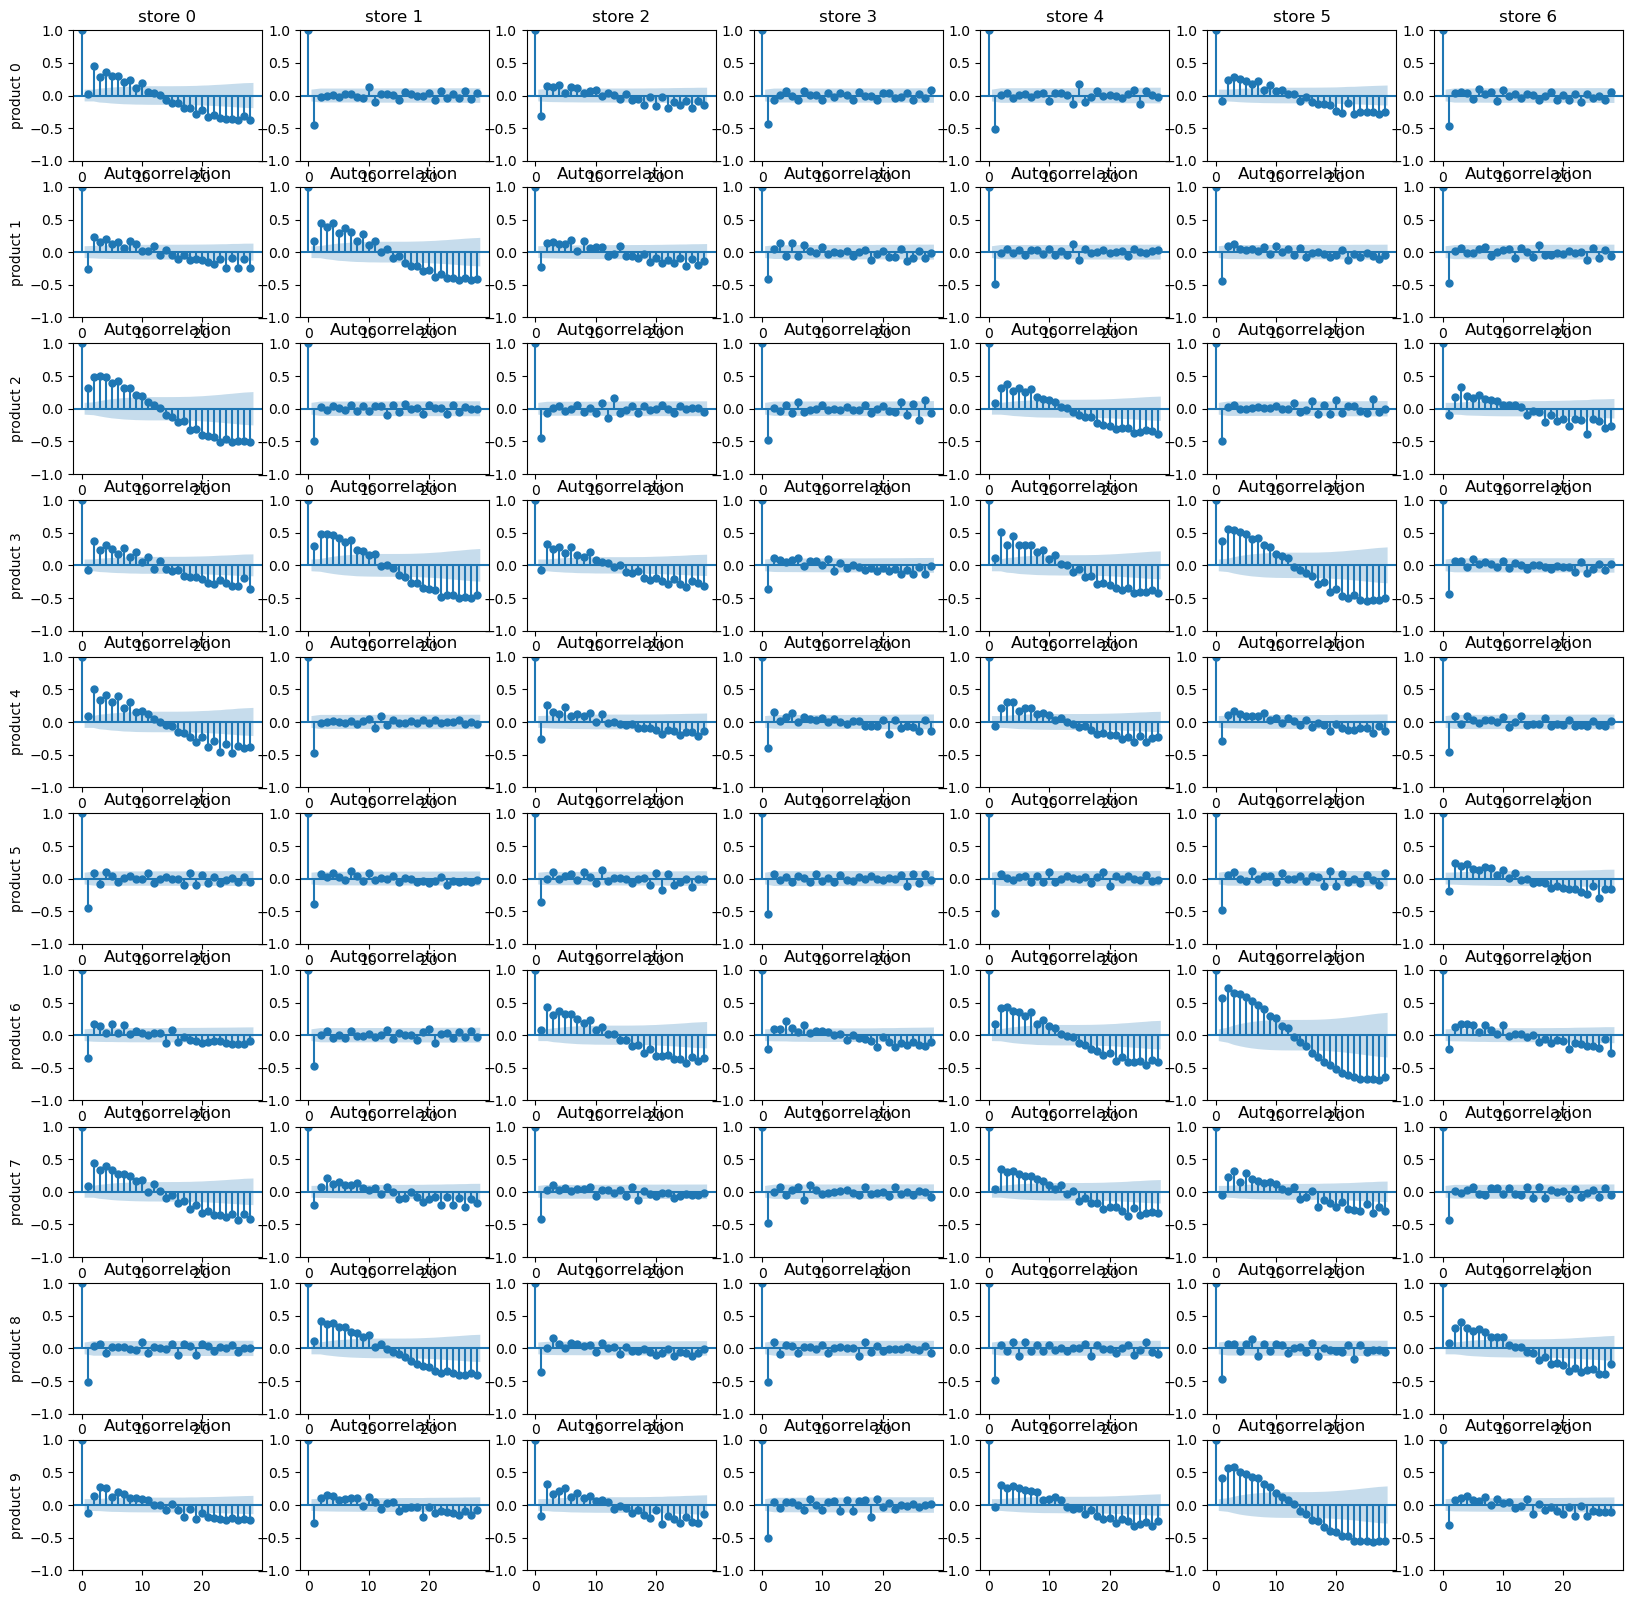

In [16]:
fig, ax = plt.subplots(10,7, figsize=(20, 20))

for s in range(7):
    for p in range(10):
        df_temp = df[(df['store']==s) & (df['product']==p)].copy(deep=True)
        df_temp = df_temp.set_index('Date').resample('W')['number_sold'].mean()
        plot_acf(df_temp.diff().dropna(), lags=28, ax=ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')


## 2.5 Plot PACF 

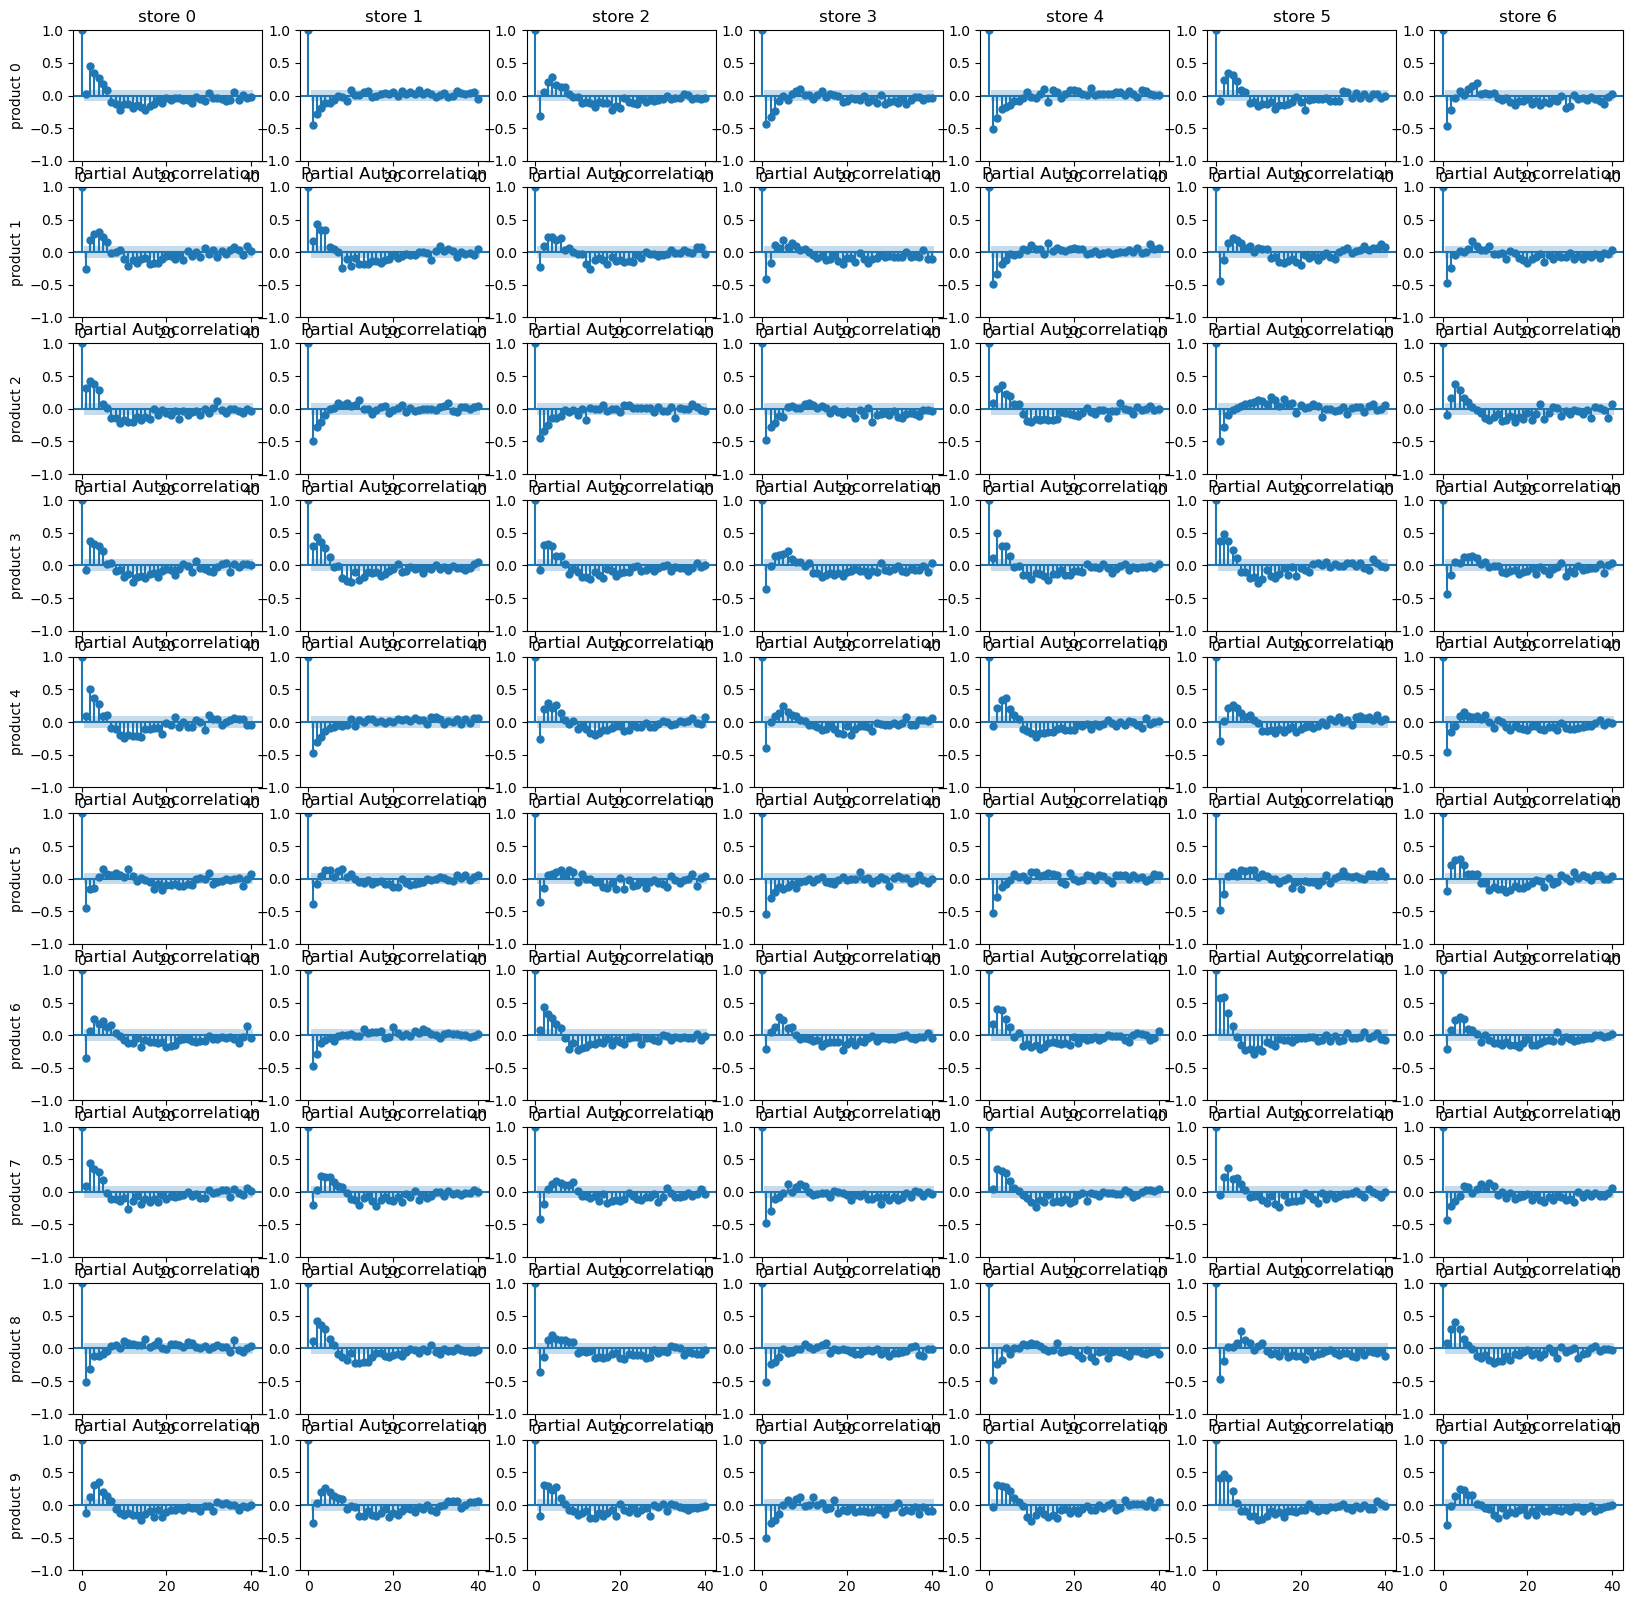

In [17]:
fig, ax = plt.subplots(10,7, figsize=(20, 20))

for s in range(7):
    for p in range(10):
        df_temp = df[(df['store']==s) & (df['product']==p)].copy(deep=True)
        df_temp = df_temp.set_index('Date').resample('W')['number_sold'].mean()
        plot_pacf(df_temp.diff().dropna(), lags=40, ax=ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')


# 3. Fit ARIMA models for all series and generate forecasts

/var/folders/k1/73gwskx154d7kvz9pjlpj_q00000gn/T/ipykernel_35980/3203787369.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_temp = df_temp.set_index('Date').resample('M')['number_sold'].mean()
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/k1/73gwskx154d7kvz9pjlpj_q00000gn/T/ipykernel_35980/3203787369.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax[p, s].plot(df_test[(df_test['store']==s) & (df_test['product']==p)].s

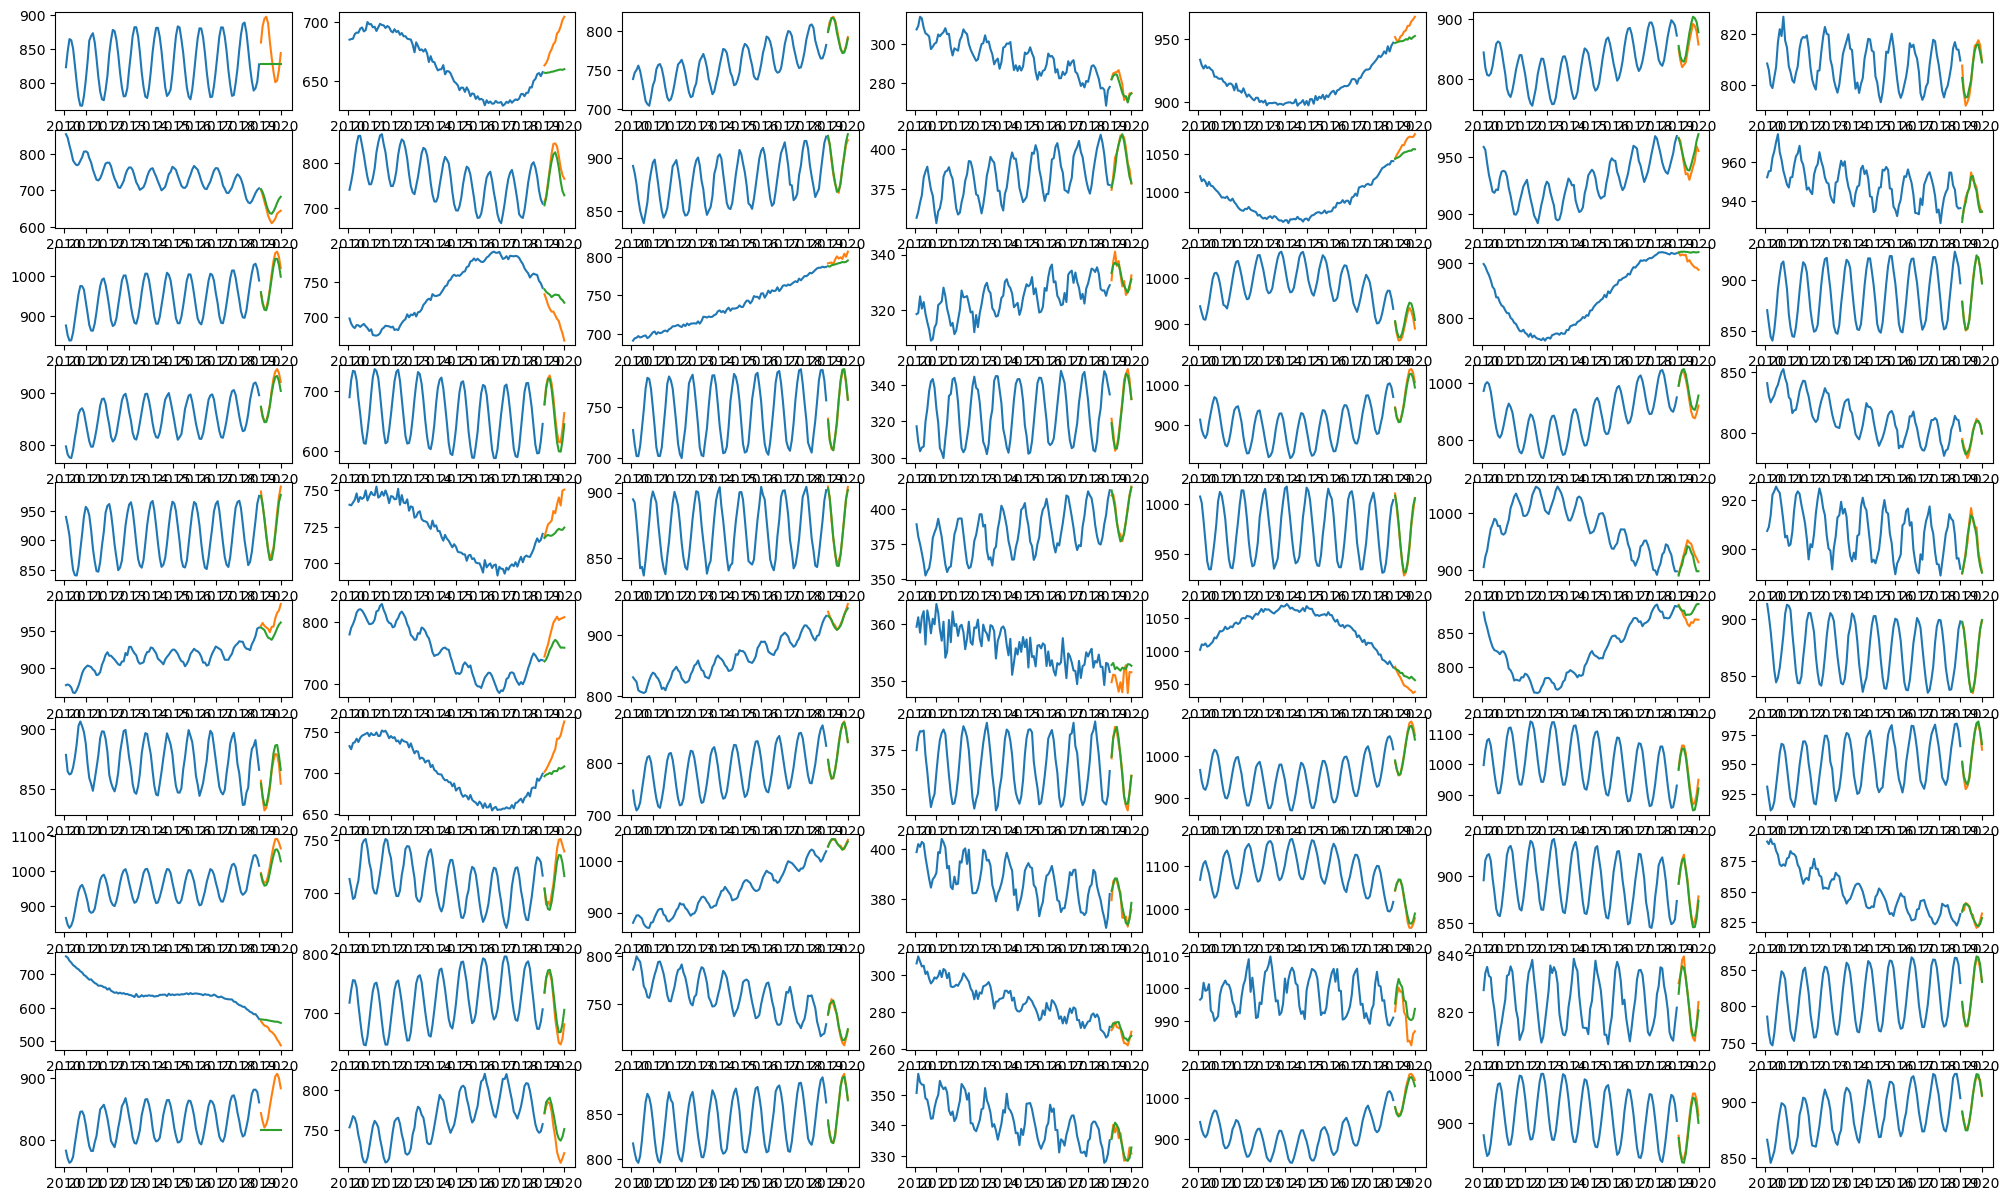

In [18]:
from statsmodels.tsa.arima.model import ARIMA
all_predictions = []
fig, ax = plt.subplots(10, 7, figsize=(25, 15))
for s in range(7):
    for p in range(10):
        df_temp = df_train[(df_train['store']==s) & (df_train['product']==p)]
        df_temp = df_temp.set_index('Date').resample('M')['number_sold'].mean()
        model = ARIMA(df_temp, 
                order = (1,0,1),
                seasonal_order = (1, 0, 1, 12))

        result = model.fit()
        predictions = result.forecast(steps=12)
        ax[p, s].plot(df_temp)
        ax[p, s].plot(df_test[(df_test['store']==s) & (df_test['product']==p)].set_index('Date').resample('M')['number_sold'].mean())
        ax[p, s].plot(predictions)

        predictions_df = predictions.reset_index()
        predictions_df['store']=s
        predictions_df['product']=p
        all_predictions.append(predictions_df)
    

Predictions are in green and as can be seen they follow quite a similar pattern with actual values (orange) in most of the cases. These could be fixed by trying out different combinations for each store - product pair. That task is beyong the purpose of this task so for simplicity we stick with a general arima for all series.

In [19]:
df_test['month'] = df_test['Date'].dt.month
df_test_month = df_test.groupby(['store', 'product', 'month'], as_index=False)['number_sold'].mean()

In [20]:
all_predictions_df = pd.concat(all_predictions)
all_predictions_df['month'] = all_predictions_df['index'].dt.month

In [21]:
df_test_combined = df_test_month.merge(all_predictions_df, on =['store', 'product', 'month'])

In [22]:
mean_absolute_percentage_error(df_test_combined['number_sold'], df_test_combined['predicted_mean'])

0.011606104655031056

# A mean absolute percentage error of 1.1% is a good result, given that on average each month sales are about 790, we are off by approximately 8.7 units from the average

# 3. Regression model

## 3.1 Prepare dataset

In [23]:
df_train2 = df_monthly.sort_values(by=['store', 'product', 'Date'])
for i in range(1,7):
    df_train2[f'y_lag_{i}'] = df_train2.groupby(['store', 'product'])['month_deviation'].shift(i)

In [24]:
df_train2['day_of_month'] = df_train2['Date'].dt.day

In [25]:
target = 'month_deviation'
cat_features = ['store', 'product']
features = ['day_of_month', 'day_of_week', 'month', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'y_lag_6'] + cat_features


In [26]:
df_train2[cat_features] = df_train2[cat_features].astype('category')

In [27]:
import lightgbm as lgb

In [28]:
df_train_temp = df_train2[df_train2['year']<2018][features + [target]].copy()
df_valid_temp = df_train2[df_train2['year']==2018][features + [target]].copy()

In [29]:
lgb_train = lgb.Dataset(df_train_temp.drop(columns=[target]), label=df_train_temp[target])
lgb_valid = lgb.Dataset(df_valid_temp.drop(columns=[target]), label=df_valid_temp[target])

In [30]:
from lightgbm import LGBMRegressor
# default parameters for training
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': "0.01",
    'num_leaves': "31",
    'subsample': "0.8",
    'colsample_bytree': "0.8",
    'reg_alpha': "0.1",
    'reg_lambda': "0.1",
    'seed': "42",
}

In [31]:
# first we fit the model with the valid set of year 2018 from training step so that we can find the number of rounds to train
# Then we use all training data to train the model until the best iteration of the first model 

first_model = lgb.train(
    params = params,
    train_set = lgb_train, 
    valid_sets=[lgb_valid],
    num_boost_round=20000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=300),
        lgb.log_evaluation(period=200)
        ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 204540, number of used features: 11
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 300 rounds
[200]	valid_0's rmse: 11.185
[400]	valid_0's rmse: 10.8478
[600]	valid_0's rmse: 10.7599
[800]	valid_0's rmse: 10.6973
[1000]	valid_0's rmse: 10.6436
[1200]	valid_0's rmse: 10.6067
[1400]	valid_0's rmse: 10.5781
[1600]	valid_0's rmse: 10.5527
[1800]	valid_0's rmse: 10.5348
[2000]	valid_0's rmse: 10.5187
[2200]	valid_0's rmse: 10.5035
[2400]	valid_0's rmse: 10.4919
[2600]	valid_0's rmse: 10.4829
[2800]	valid_0's rmse: 10.4732
[3000]	valid_0's rmse: 10.4663
[3200]	valid_0's rmse: 10.4563
[3400]	valid_0's rmse: 10.4471
[3600]	v

In [32]:
# Train the model with all training Data
lgb_train_final = lgb.Dataset(df_train2[features], label=df_train2[target])

model_final = lgb.train(
    params = params,
    train_set = lgb_train_final, 
    num_boost_round=first_model.best_iteration,
    callbacks=[
        lgb.log_evaluation(period=200)
        ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 230090, number of used features: 11
[LightGBM] [Info] Start training from score -0.000000


In [33]:
df_test_new = df_test.copy()
df_test_new['day_of_month'] = df_test_new['Date'].dt.day
df_test_new['day_of_week'] = df_test_new['Date'].dt.isocalendar()['week']
df_test_new['month'] = df_test_new['Date'].dt.month

In [34]:
# Since we cannot use data in the test set, we will use predictions 
# generated each day to feed them as lagged variables (y_lag_1, ...)

def func_roll_over(df_pred_old, df_test_new, df_train, dt):
    df_temp = pd.concat([df_test_new[df_test_new['Date'].astype('str')==dt], df_train, df_pred_old])
    df_temp.sort_values(by=['store', 'product', 'Date'], inplace=True)
    for i in range(1,7):
        df_temp[f'y_lag_{i}'] = df_temp.groupby(['store', 'product'])['month_deviation'].shift(i)
    pred_df = df_temp[df_temp['Date'].astype('str')==dt][features]
    pred_df[cat_features] = pred_df[cat_features].astype('category')
    pred_df['month_deviation'] = model_final.predict(pred_df[features])
    pred_df['Date'] = pd.to_datetime(dt)
    return pred_df

In [ ]:
# generate predictions of monthly deviation for the whole year
preds = []
pred_old = pd.DataFrame()
i = 1
for dt in sorted(df_test['Date'].astype('str').unique()):
    pred_old = func_roll_over(pred_old, df_test_new, df_monthly, dt)
    preds.append(pred_old)
    if i> 1:
        pred_old = pd.concat(preds)
    i+=1

<Axes: >

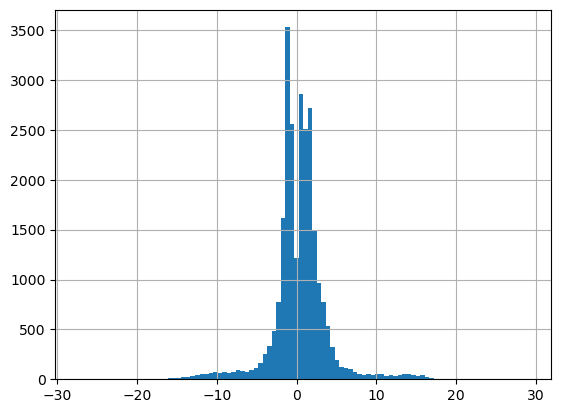

In [36]:
# histogram of the predictions by the model 
preds_daily = pd.concat(preds)
preds_daily['month_deviation'].hist(bins=100)

# Combine Predictions

In [40]:
final_preds= preds_daily.merge(
    df_test_combined[['store', 'product', 'month', 'predicted_mean']],
    on =['store', 'product', 'month'],
    how='left'
    )
final_preds['final_pred'] = (final_preds['month_deviation'] + final_preds['predicted_mean']).apply(lambda x: int(x))
# Add actual values from test_set 
final_preds = final_preds.merge(
    df_test[['store', 'product', 'Date', 'number_sold']],
    on = ['store', 'product', 'Date'],
    )

In [41]:
mean_absolute_percentage_error(final_preds['number_sold'], final_preds['final_pred'])

0.020720127399706172

In [42]:
# store train df for lightgbm model so that we can use for HP tunning in another notebook
df_train2[
    ['Date', 'store', 'product', 'day_of_week', 'month','year', 'month_deviation', 
     'day_of_month', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'y_lag_6']
     ].to_csv('data/hp_tunning_df.csv', index=False)